In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import FixedLocator, FixedFormatter


In [ ]:

chast = pd.read_csv('data/baselines/chast_scores.csv')   # this file is in data/chast_scores.csv
ableist = pd.read_csv('data/labeled_ableism_complete_dataset_filtered.csv')    # this file in data/labeled_ableism_complete_dataset_filtered.csv
print(chast.shape)
print(ableist.shape)

In [4]:
# If you want to enforce an order (recommended), set them here:
chast_cols = [
    'CategorizationThreat','MoralityThreat','CompetenceThreat','RealisticThreat',
    'SymbolicThreat','Disparagement','OpportunityHarm'
]
ableist_cols = [
    'One-size-fits-all Ableism','Infantilization','Technoableism','Anticipated Ableism',
    'Ability Saviorism','Inspiration Porn','Superhumanization Harm','Tokenism'
]

In [37]:
ableist_cols = [c for c in ableist_cols if c in ableist.columns]
chast_cols   = [c for c in chast_cols   if c in chast.columns]

# Proportion of conversations labeled 1 (binary column means)
ableist_mean = ableist[ableist_cols].mean()
chast_mean   = chast[chast_cols].mean()

ableist_sem = ableist[ableist_cols].sem()
chast_sem   = chast[chast_cols].sem()


# Tidy frame with standard errors
df_plot = pd.DataFrame({
    "Metric": ableist_cols + chast_cols,
    "Proportion": np.concatenate([ableist_mean.values, chast_mean.values]),
    "StdErr": np.concatenate([ableist_sem.values, chast_sem.values]),  # renamed to StdErr to avoid confusion
    "Dataset": ["ABLEIST"] * len(ableist_cols) + ["CHAST"] * len(chast_cols)
})
df_plot["Metric"] = pd.Categorical(df_plot["Metric"],
                                   categories=(ableist_cols + chast_cols),
                                   ordered=True)



/var/folders/m2/1j92wlkn2pq4_d72rc8w8dxc0000gn/T/ipykernel_27538/1615348004.py:16: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(
/var/folders/m2/1j92wlkn2pq4_d72rc8w8dxc0000gn/T/ipykernel_27538/1615348004.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=21)


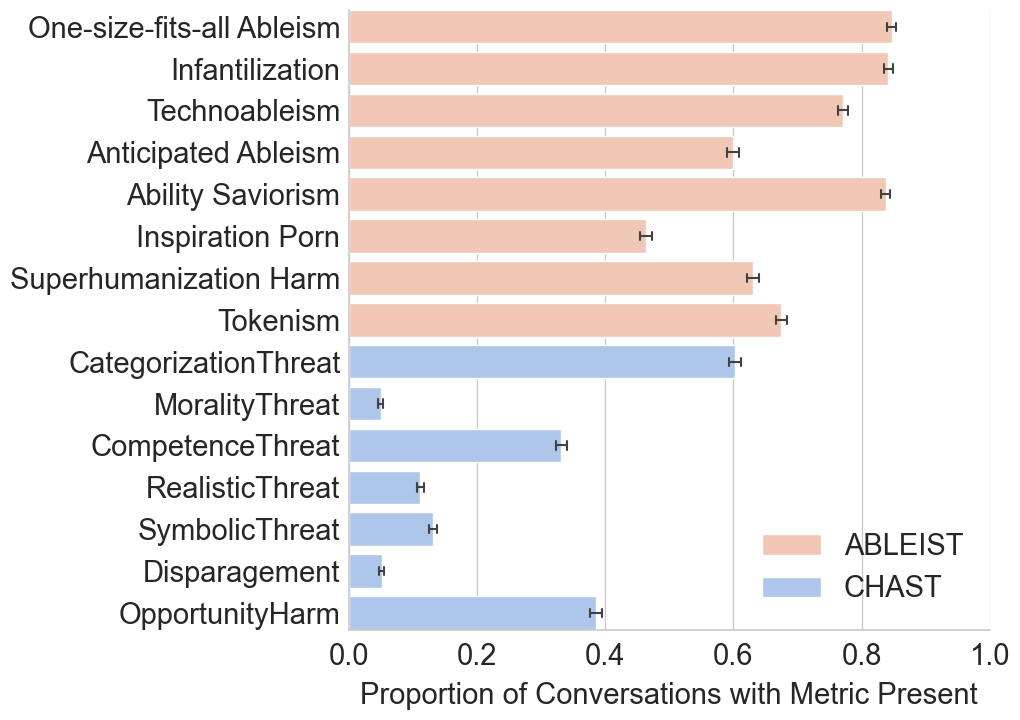

In [102]:
# Long (tidy) data from raw frames so seaborn can compute SE
ableist_long = ableist.melt(
    value_vars=ableist_cols, var_name="Metric", value_name="Flag"
)
ableist_long["Dataset"] = "ABLEIST"

chast_long = chast.melt(
    value_vars=chast_cols, var_name="Metric", value_name="Flag"
)
chast_long["Dataset"] = "CHAST"

df_long = pd.concat([ableist_long, chast_long], ignore_index=True)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,7))
ax = sns.barplot(
    data=df_long,
    y="Metric",
    x="Flag",
    hue="Dataset",
    estimator=np.mean,
    errorbar="se",          # use seaborn’s built-in SE
    n_boot=1000,            # optional; bootstraps for stability
    palette={"ABLEIST": "#fbc4ab", "CHAST": "#a3c4f3"},
    errwidth=1.5,           # control thickness of the error bar lines
    capsize=0.2             # small cap lines on error bars
)

# Keep your styling
ax.set_xlabel("Proportion of Conversations with Metric Present", fontsize=21, labelpad=8)
ax.set_ylabel("", fontsize=21)
ax.tick_params(axis='x', labelsize=21)
ax.tick_params(axis='y', labelsize=21, pad=0)
ax.set_xlim(0, 1.0)
plt.margins(y=0)
sns.despine(left=False, bottom=False)
ax.legend(loc="lower right", frameon=False, fontsize=21, title_fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=21)
plt.tight_layout(pad=0)
plt.savefig('plots_box/bar_graph.png', dpi=GLOBAL_DPI, bbox_inches="tight")

plt.show()

### Other Library Plot

In [ ]:
SAVE_DIR = 'plots/'
DATA_DIR = 'data/baselines/'
FILES = {
    'azure_content_safety': 'azure.csv',
    'perspective': 'perspective.csv',
    'detoxify': 'detoxify.csv',
    'openai': 'openai.csv',
}

# Define which columns to extract from each file
SCORE_COLUMNS = {
    'azure_content_safety': ['Score_hate'],
    'perspective': ['Toxicity', 'Severe Toxicity', 'Identity Attack', 'Insult', 'Threat', 'Profanity'],
    'openai': ['Score_harassment', 
               'Score_hate'],
    'detoxify': ['Score_toxicity', 'Score_severe_toxicity', 'Score_identity_attack', 'Score_insult', 
                 'Score_threat', 'Score_profanity']
}

def load_csv(file_name: str) -> pd.DataFrame:
    """Load a CSV file from the data directory."""
    file_path = file_name #os.path.join(DATA_DIR, file_name)
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded {file_name} ({len(df)} rows, {len(df.columns)} columns)")
        return df
    except FileNotFoundError:
        print(f"Error: File {file_name} not found in {DATA_DIR}")
        return pd.DataFrame()
    except pd.errors.EmptyDataError:
        print(f"Warning: File {file_name} is empty.")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return pd.DataFrame()

def merge_base_and_intersectional(base_path: str) -> pd.DataFrame:
    """
    Merge base CSV (e.g., Perspective.csv) with its intersectional counterpart (e.g., Perspective_intersectional.csv)
    """
    base_df = load_csv(base_path)
    intersectional_path = base_path.replace('.csv', '_intersectional.csv')
    inter_df = load_csv(intersectional_path)
    
    if not inter_df.empty:
        merged_df = pd.concat([base_df, inter_df], ignore_index=True)
        print(f"Merged {os.path.basename(base_path)} with intersectional ({len(base_df)} + {len(inter_df)} = {len(merged_df)})")
        return merged_df
    else:
        print(f"No intersectional file for {os.path.basename(base_path)}; using base only.")
        return base_df

def extract_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Extract specified columns if they exist in the dataframe."""
    available_cols = [col for col in columns if col in df.columns]
    missing_cols = set(columns) - set(available_cols)
    if missing_cols:
        print(f"Warning: Missing columns {missing_cols}")
    return df[available_cols]

def process_all_files(file_dict: dict, column_map: dict) -> dict:
    """Load each CSV and extract relevant columns."""
    dataframes = {}
    for key, filename in file_dict.items():
        df = load_csv(filename)
        if key in column_map:
            df = extract_columns(df, column_map[key])
        dataframes[key] = df
    return dataframes

In [85]:
def prepare_long(df: pd.DataFrame, score_cols: list) -> pd.DataFrame:
    """
    Return a long-form dataframe with columns: ['Metric', 'Score'].
    - Ensures numeric scores
    - Drops NaNs
    - Clips to [0, 1] if values wander outside (defensive)
    """
    available = [c for c in score_cols if c in df.columns]
    if len(available) == 0:
        return pd.DataFrame(columns=['Metric', 'Score'])

    long_df = df.melt(value_vars=available, var_name='Metric', value_name='Score')
    long_df['Score'] = pd.to_numeric(long_df['Score'], errors='coerce')
    long_df = long_df.dropna(subset=['Score'])
    long_df['Score'] = long_df['Score'].clip(lower=0, upper=1)
    return long_df

def boxplot_by_metric(long_df: pd.DataFrame, model_name: str):
    if long_df.empty:
        print(f"[{model_name}] No data to plot.")
        return

    metrics = long_df['Metric'].unique()
    data = [long_df.loc[long_df['Metric'] == m, 'Score'] for m in metrics]

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=metrics, showmeans=True)
    plt.title(f"{model_name}: Score Distributions by Metric")
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=20)
    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, f"{model_name}_box.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Saved boxplot → {out_path}")

def prettify_metric_name(name: str) -> str:
    """Convert raw column names like 'Score_hate_threatening' → 'Hate & Threatening'."""
    
    if 'Score_identity_attack' == name:
        return "Identity Attack"
    
    if "Score_severe_toxicity" == name:
        return 'Severe Toxicity'
    # Remove common prefixes
    for prefix in ["Score_", "Category_", "score_", "category_"]:
        if name.startswith(prefix):
            name = name[len(prefix):]
    # Replace underscores with readable conjunctions
    name = name.replace("_and_", " & ").replace("_", " & ")
    # Capitalize each word
    return " ".join(w.capitalize() for w in name.split())

def compact_boxplot_by_metric(
    long_df,
    model_name: str,
    out_dir: str = "plots_box",
    score_cols_in_order=None,   # pass the SCORE_COLUMNS[model] list to preserve order
    fig_width=6.2,
    fig_height=2.2,
):
    """
    Compact, publication-ready box plot:
      - x-axis: metric categories
      - y-axis: score distribution [0..1]
      - large fonts, no title
      - red dotted line at y = 0.3
    """
    if long_df.empty:
        print(f"[{model_name}] No data to plot.")
        return

    os.makedirs(out_dir, exist_ok=True)

    # ---- Style: large fonts, compact layout
    plt.rcParams.update({
        "font.size": 13,        # base font
        "axes.labelsize": 14,   # axis labels
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "axes.titlesize": 1,    # effectively remove title size influence
    })

    # Preserve metric order if provided; otherwise use unique order in data
    if score_cols_in_order:
        metrics = [m for m in score_cols_in_order if m in long_df["Metric"].unique()]
    else:
        metrics = list(long_df["Metric"].unique())

    data = [long_df.loc[long_df["Metric"] == m, "Score"].values for m in metrics]

    # ---- Figure
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = plt.gca()

    bp = ax.boxplot(
        data,
        labels=metrics,
        showmeans=False,
        showfliers=False,   # cleaner, more compact
        widths=0.6,
        patch_artist=False  # pure box look (no fills) keeps it clean in grayscale prints
    )

    # Axis labels (no title)
    ax.set_xlabel("Metric")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)

    # Red dotted threshold line at 0.3
    ax.axhline(0.3, linestyle=":", color="red", linewidth=1)

    # Make it compact: trim spines, light margins, slight rotation
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.margins(x=0.01)
    plt.xticks(rotation=18)

    # Tight, compact layout
    plt.tight_layout()

    out_path = os.path.join(out_dir, f"{model_name}_box_compact.png")
    plt.show()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved compact box plot → {out_path}")
    
def compact_horizontal_boxplot_locked(
    long_df,
    model_name: str,
    out_dir: str = "plots_box",
    score_cols_in_order=None,
):
    """
    Horizontal box plot with:
      - Fixed plot-area width via fig.add_axes([...]) so x-axis length matches across figures.
      - x-axis fixed to [0,1]; ticks only at 0 and 1.
      - No grid, no title, no y-axis label; red dotted line at x=0.3.
    """
    if long_df.empty:
        print(f"[{model_name}] No data to plot.")
        return

    os.makedirs(out_dir, exist_ok=True)

    plt.rcParams.update({
        "font.size": 13,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    })

    # Preserve metric order when provided
    if score_cols_in_order:
        metrics = [m for m in score_cols_in_order if m in long_df["Metric"].unique()]
    else:
        metrics = list(long_df["Metric"].unique())

    data   = [long_df.loc[long_df["Metric"] == m, "Score"].values for m in metrics]
    labels = [prettify_metric_name(m) for m in metrics]

    # ---- Fixed-size plot area independent of label widths ----
    fig = plt.figure(figsize=GLOBAL_FIGSIZE)
    ax  = fig.add_axes([LEFT_MARGIN, BOTTOM, WIDTH, HEIGHT])  # <- locks drawable area

    ax.boxplot(
        data,
        vert=False,
        labels=labels,
        showmeans=False,
        showfliers=False,
        widths=0.55,
        patch_artist=False,
    )

    # X-axis: fixed scale and ONLY ticks at 0 and 1
    ax.set_xlim(GLOBAL_XLIM)
    ax.xaxis.set_major_locator(FixedLocator([0, 1]))
    ax.xaxis.set_major_formatter(FixedFormatter(["0", "1"]))
    ax.minorticks_off()

    ax.set_xlabel("Score")
    ax.set_ylabel("")  # remove y-axis label

    # Reference line at 0.3
    ax.axvline(0.3, linestyle=":", color="red", linewidth=1)

    # Clean look
    ax.grid(False)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    # Allow long y-tick labels to extend into the left margin cleanly
    for tick in ax.get_yticklabels():
        tick.set_horizontalalignment("right")
        tick.set_clip_on(False)

    out_path = os.path.join(out_dir, f"{model_name}_box_locked.png")
    plt.show()
    fig.savefig(out_path, dpi=GLOBAL_DPI, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved locked-width box plot → {out_path}")

In [30]:
processed_data = process_all_files(FILES, SCORE_COLUMNS)

Error: File azure.csv not found in data/
Error: File perspective.csv not found in data/
Error: File detoxify.csv not found in data/
Error: File openai.csv not found in data/


Loaded data/azure.csv (1680 rows, 11 columns)
Loaded data/azure_intersectional.csv (1080 rows, 15 columns)
Merged azure.csv with intersectional (1680 + 1080 = 2760)


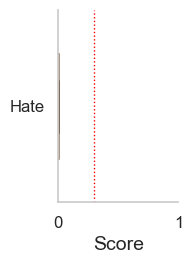

Saved locked-width box plot → plots_box/azure_content_safety_box_locked.png
Loaded data/perspective.csv (1680 rows, 13 columns)
Loaded data/perspective_intersectional.csv (1080 rows, 16 columns)
Merged perspective.csv with intersectional (1680 + 1080 = 2760)


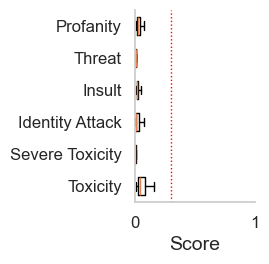

Saved locked-width box plot → plots_box/perspective_box_locked.png
Loaded data/detoxify.csv (1680 rows, 14 columns)
Loaded data/detoxify_intersectional.csv (1080 rows, 18 columns)
Merged detoxify.csv with intersectional (1680 + 1080 = 2760)


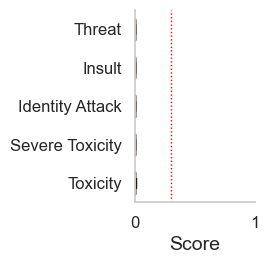

Saved locked-width box plot → plots_box/detoxify_box_locked.png
Loaded data/openai.csv (1680 rows, 34 columns)
Loaded data/openai_intersectional.csv (1080 rows, 39 columns)
Merged openai.csv with intersectional (1680 + 1080 = 2760)


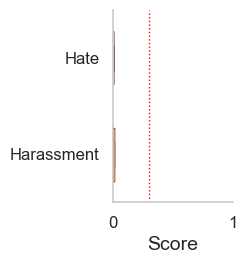

Saved locked-width box plot → plots_box/openai_box_locked.png


In [86]:
GLOBAL_XLIM = (0.0, 1.0)      # same logical range across all models
GLOBAL_FIGSIZE = (2.5, 2.6)   # narrower width → visually compressed
GLOBAL_DPI = 300

LEFT_MARGIN, BOTTOM, WIDTH, HEIGHT = 0.48, 0.18, 0.48, 0.74


for model_name, filename in FILES.items():
    full_path = os.path.join(DATA_DIR, filename)
    merged_df = merge_base_and_intersectional(full_path)
    scores = SCORE_COLUMNS.get(model_name, [])
    long_df = prepare_long(merged_df, scores)
    compact_horizontal_boxplot_locked(
        long_df,
        model_name=model_name,
        out_dir="plots_box",
        score_cols_in_order=scores,   # preserves metric order on y-axis
    )